# playing Atari with Deep Learning
* ohne Frame Stack
* kein Replay Memory und Epsilon Greedy

(*) Bilder müssen auf kleineres Format reshaped werden als Original (210, 160, 3), da sonst zu Groß für GPU

## 1. Datensatz generieren per Zufallsspiel.
Es werden nur Sequenzen gespeichert, die einen Reward zurückgeben.

In [1]:
# choose game
game = "Pong-v0"

In [2]:
import gym
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

# zum erstellen des Spiels mit Wrappern
def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

In [28]:
import numpy as np

env = WarpFrameEnv(game)
x_data = [] # Bilder (States)
y_data = [] # Label (Aktionen)

DATASET_SIZE = 1000
saved_episodes = 0

# Datensatz generieren
the_end = False
while not the_end:
    done = False
    state = env.reset()
    episode_obs = []
    episode_acts = []
  
    while not done:
        action = env.action_space.sample()
        episode_obs.append(state)
        episode_acts.append(action)
        state, reward, done, info = env.step(action)
    
        if reward < 0:
            episode_acts = []
            episode_obs = []
        elif reward > 0:
            x_data += episode_obs
            y_data += episode_acts
            episode_obs = []
            episode_acts = []
            saved_episodes += 1
            print(saved_episodes)
            if saved_episodes+1 > DATASET_SIZE:
                print("Dataset completed")
                the_end = True

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [29]:
# Teilen in Training und Test, shuffeln des Datensatzes
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=0.2)

In [30]:
# konvertieren in richtiges Format
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

## 2. Erstellen des künstlichen neuronalen Netzes

In [31]:
# Input und Output shape
INPUT_SHAPE = np.shape(x_data)[1:]
OUTPUT_SHAPE = 1

In [35]:
import tensorflow
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

net_input = Input(shape=INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
x = Activation("relu")(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation("relu")(x)
net_output = Dense(OUTPUT_SHAPE)(x)

LOSS_FUNCTION = Huber()
OPTIMIZER = Adam(lr=0.0005)

model = Model(inputs=net_input, outputs=net_output)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=["mae"])

In [36]:
EPOCHS = 30

training = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/30
62140/62140 [==============================] - 21s 331us/sample - loss: 1.2103 - mae: 1.6579
Epoch 2/30
62140/62140 [==============================] - 20s 321us/sample - loss: 1.0650 - mae: 1.5139
Epoch 3/30
62140/62140 [==============================] - 19s 311us/sample - loss: 1.0608 - mae: 1.5104
Epoch 4/30
62140/62140 [==============================] - 19s 306us/sample - loss: 1.0589 - mae: 1.5103
Epoch 5/30
62140/62140 [==============================] - 19s 302us/sample - loss: 1.0581 - mae: 1.5096
Epoch 6/30
62140/62140 [==============================] - 19s 304us/sample - loss: 1.0575 - mae: 1.5102
Epoch 7/30
62140/62140 [==============================] - 21s 334us/sample - loss: 1.0579 - mae: 1.5113
Epoch 8/30
62140/62140 [==============================] - 19s 304us/sample - loss: 1.0561 - mae: 1.5097
Epoch 9/30
62140/62140 [==============================] - 18s 297us/sample - loss: 1.0555 - mae: 1.5107
Epoch 10/30
62140/62140 [==============================] - 19s 3

In [39]:
model.evaluate(x_test, y_test, verbose=0)

[1.0479866193202694, 1.5062817]

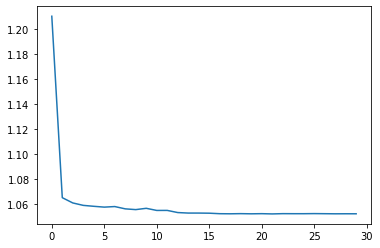

In [40]:
import matplotlib.pyplot as plt
model_hist = training.history
plt.plot(model_hist['loss'])
plt.show()

In [46]:
model.predict(x_test)

array([[2.4460096],
       [2.4460096],
       [2.4460096],
       ...,
       [2.4460096],
       [2.4460096],
       [2.4460096]], dtype=float32)

## 3. Spielen mit trainiertem neuronalen Netz

In [41]:
EPISODES = 5

for episode in range(EPISODES):
    state = env.reset()
    done = False
    Episode_Reward = 0
    while not done:
        action = model.predict(state)
        state, reward, done, info = env.step(action)
        Episode_Reward += reward
        
        if done:
            print("Episode:", episode, "\tReward:", Episode_Reward)

ValueError: Error when checking input: expected input_4 to have 4 dimensions, but got array with shape (84, 84, 1)